In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from abc import ABC, abstractmethod
from collections import defaultdict

%matplotlib inline

In [2]:
def shermanMorrison(V:np.ndarray, x:np.ndarray):
    """
    ${V_t}^{-1} = V_{t-1}^{-1} - \frac{V_{t-1}^{-1}xx^T V_{t-1}^{-1}}{1 + x^T V_{t-1}^{-1} x}$
    V: inverse of old gram matrix, corresponding to $V_{t-1}$.
    x: a new observed context
    return: inverse of new gram matrix
    """
    numerator = np.einsum("ij, j, k, kl -> il", V, x, x, V)
    denominator = (1 + np.einsum("i, ij, j ->", x, V, x))
    return V - (numerator / denominator)


def l2norm(v:np.ndarray):
    v = v.flatten()
    return np.sqrt(np.sum(v ** 2))


def matrix_norm(m:np.ndarray, frobenius:bool):
    assert len(m.shape) == 2
    if frobenius:
        ## frobenius norm
        return np.linalg.norm(m)
    ## spectral norm
    return np.linalg.norm(m, 2)


def covariance_generator(d:int, bound:float=1.):
    rnd = np.random.randn(d, d)
    ## make a symmetric matrix
    sym = (rnd + rnd.T) / 2
    ## make positive semi-definite and bound its maximum singular value
    mat = sym @ sym.T
    return mat


def minmax(v:np.ndarray, bound:float=1.):
    min = np.min(v)
    max = np.max(v)
    return ((v - min) / (max - min)) * bound


def left_pseudo_inverse(A:np.ndarray):
    d, k = A.shape
    u, A_sig, v_T = np.linalg.svd(A)
    
    B_sig = np.zeros((k, d))
    for i in range(k):
        B_sig[i, i] = 1 / A_sig[i]
    
    B = v_T.T @ B_sig @ u.T
    
    return B


def rademacher(size:int):
    """
    Generate Rademacher random variables.

    Args:
    size (int): Number of random variables to generate.

    Returns:
    numpy.ndarray: An array of Rademacher random variables.
    """
    return 2 * np.random.randint(0, 2, size) - 1


def subgaussian_noise(distribution:str, size:int, var:float=None):
    """
    distribution (str): the distribution to sample a sub-Gaussian noise
    size (int): The number of total rounds (T)
    var (float): The variance proxy of the noise
    """
    if not var:
        assert distribution in ["gaussian", "uniform"]
    
    if distribution == "gaussian":
        if not var:
            var = 1
        noise = np.random.normal(loc=0, scale=var, size=size) 
    elif distribution == "uniform":
        if not var:
            low = -1
            high = 1
            var = ((high - low) ** 2) / 12
        else:
            low = -np.sqrt(3 * var)
            high = np.sqrt(3 * var)
        noise = np.random.uniform(low=low, high=high, size=size)
    else:
        var = 1
        noise = rademacher(size=size)
    return noise, var

In [3]:
## Agent
class ContextualBandit(ABC):
    @abstractmethod
    def choose(self, x): pass
    
    @abstractmethod
    def update(self, x, r): pass
    
    
class LinUCB(ContextualBandit):
    def __init__(self, d, N, alpha, lbda=1):
        self.d = d # dimension of observable features
        self.N = N # number of actions
        self.alpha = alpha
        self.t = 0
        self.xty = np.zeros(d + N)
        self.Vinv = (1 / lbda) * np.identity(d + N)
        self.unseen = np.identity(N)
        
    def choose(self, x):
        # x: action set at each round (N, d)
        self.t += 1
        
        ## compute the ridge estimator
        theta_hat = self.Vinv @ self.xty
        
        ## observe the context
        x = np.concatenate((x, self.unseen), axis=1) # now x: (N, d) -> (N, d+N)
        
        ## compute the ucb scores for each arm
        expected = x @ theta_hat # (N, ) theta_T @ x_t
        width = np.sqrt(np.einsum("Ni, ij, Nj -> N", x, self.Vinv, x) * np.log(self.t)) # (N, ) widths
        ucb_scores = expected + (self.alpha * width) # (N, ) ucb score
        
        ## chose the argmax the ucb score
        maximum = np.max(ucb_scores)
        argmax, = np.where(ucb_scores == maximum)
        
        return np.random.choice(argmax)
    
    def update(self, x, a, r):
        # x: context of the chosen action (d, )
        # a: index of the chosen action
        x = np.concatenate((x, self.unseen[a, :]))
        self.Vinv = shermanMorrison(self.Vinv, x)
        self.xty += (r * x)

In [4]:
d = 10       # dimension of context vectors
N = 10       # number of arms
num_samples = 30000    # number of samples
T = 20000    # number of rounds
SEED = 777  # random seed
sigma = 1.0  # std of noise in reward
verbose = True #whether to print the results of each round or not

In [5]:
np.random.seed(SEED)

X = np.random.multivariate_normal(mean=np.zeros(d), cov=np.identity(d), size=num_samples)

# X_cov = covariance_generator(d)
# X = np.random.multivariate_normal(mean=np.zeros(d), cov=X_cov, size=num_samples)

print(X)

beta = np.random.random(d)
print(beta)

mu = np.random.random(num_samples) # rewards inherent to arms
Y = X @ beta + mu + sigma * np.random.randn(num_samples) # add gaussian noise
print(Y, Y.shape)

[[-0.46820879 -0.82282485 -0.0653801  ... -1.32368279 -1.75244452
   1.00244907]
 [ 0.54480945  1.8951609  -0.76935745 ... -0.43950352  0.91478726
   0.26504093]
 [-1.38337015  0.6855118   0.45609091 ...  0.45686676 -0.31387278
   0.02103738]
 ...
 [ 0.68805738  0.60176538  0.44130889 ...  0.99105062 -0.50196164
  -0.83805207]
 [-0.24326337  0.66254473  1.83434424 ...  0.01872692 -0.09020919
   1.21328786]
 [-0.06611205  0.51535374  0.29703139 ...  0.28094173 -1.44170208
   0.38978468]]
[0.81601177 0.68220181 0.17654939 0.9238038  0.98717478 0.43288008
 0.93628504 0.73428019 0.1052257  0.0792962 ]
[ 0.05432535 -0.73581455  0.31360409 ...  2.87902363 -0.45700633
 -1.19006914] (30000,)


In [6]:
def run(agent:LinUCB, horizon:int, num_space:int, num_actions:int, action_space:np.ndarray, reward_param:np.ndarray, 
        reward:np.ndarray, inherent:np.ndarray, use_tqdm:bool=True, verbose:bool=False):
    if use_tqdm:
        bar = tqdm(range(horizon))
    else:
        bar = range(horizon)
        
    regrets = np.zeros(horizon)
    
    for t in bar:
        indices = np.random.randint(0, num_space, num_actions) # sample action set for each round
        action_set, reward_set, inherent_set = action_space[indices], reward[indices], inherent[indices]
#         exp_rewards = action_set @ reward_param + inherent_set
        exp_rewards = action_set @ reward_param
        optimal_action = np.argmax(exp_rewards)
        optimal_reward = exp_rewards[optimal_action]

        ## choose the best action
        chosen_arm = agent.choose(action_set)    # index in the action set
        chosen_context = action_set[chosen_arm]
        
        ## observe the reward
        chosen_reward = reward_set[chosen_arm]
        
        ## compute the regret
        instance_regret = optimal_reward - exp_rewards[chosen_arm]
        regrets[t] = instance_regret
        
        ## update the agent
        agent.update(chosen_context, chosen_arm, chosen_reward)
        
        if verbose: 
            print(f"round {t+1}, optimal action : {optimal_action}, optimal reward : {optimal_reward:.3f}, chosen action : {chosen_arm}")
            print(f"\trealized reward : {chosen_reward:.3f}, expected reward: {exp_rewards[chosen_arm]:.3f}, regret : {instance_regret:.3f}, cum.regret : {np.sum(regrets):.3f}")
            
    return regrets

In [7]:
alphas = [0.0, 0.1, 1.0, 5.0]
regret_result = dict()
for alpha in alphas:
    agent = LinUCB(d, N, alpha)
    regrets = run(agent=agent, horizon=T, num_space=num_samples, num_actions=N, 
                  action_space=X, reward_param=beta, reward=Y, inherent=mu)
    regret_result[alpha] = regrets

100%|██████████| 20000/20000 [00:18<00:00, 1077.08it/s]


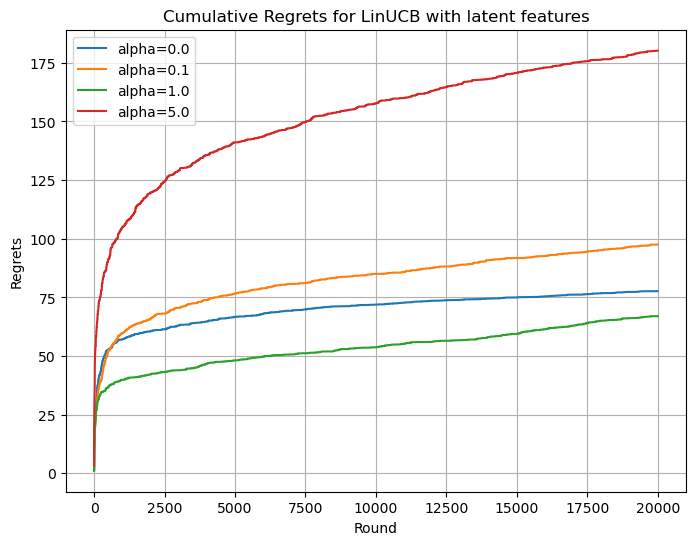

In [8]:
plt.figure(figsize=(8, 6))
for alpha in alphas:
    plt.plot(np.cumsum(regret_result[alpha]), label=f"alpha={alpha}")
# plt.plot((d+N) * np.sqrt(np.arange(T)), label="$(d+K)\sqrt{T}$")

plt.grid(True)
plt.title('Cumulative Regrets for LinUCB with latent features')
plt.xlabel('Round')
plt.ylabel('Regrets')
plt.legend()
plt.show()